# Simulate Fire Locations

In [1]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2
pylab.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['figure.figsize'] = (10,10)

import pandas as pd
import math
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation


Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("SF_fire_incidents/Fire_Incidents.csv", dtype=object)
df.index = pd.to_datetime(df['Incident Date'], format= "%m/%d/%Y")

In [3]:
#Extract float latitude and longitude from Location (string)
def getcoordfstr(location):
    return re.findall(r"[-+]?\d*\.\d+|\d+", location)


df['Latitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[0]) if not pd.isnull(x) else x)
df['Longitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[1]) if not pd.isnull(x) else x)

Number of fires between 2016-01-01 and 2016-06-01 is 12899


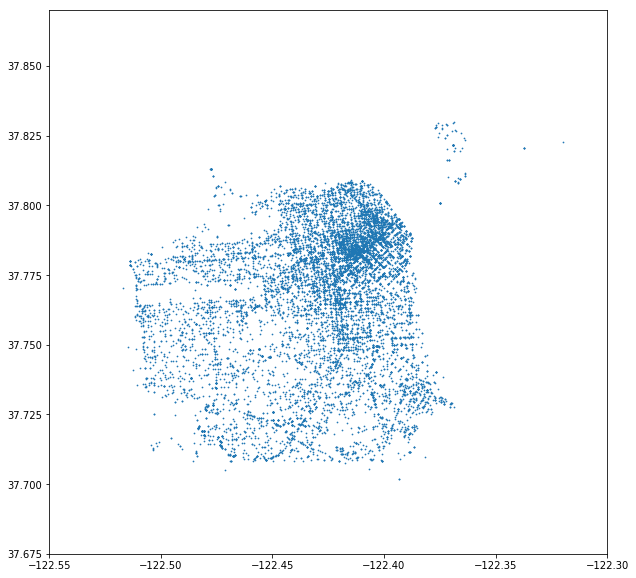

In [4]:
start = "2016-01-01"
end = "2016-06-01"
x = df['Longitude'].dropna()
y = df['Latitude'].dropna()
print("Number of fires between {} and {} is {}".format(start, end, len(x[start:end])))
#plt.scatter(x[start:end], y[start:end], s=0.5)
ax = plt.subplot(111)
#ax.scatter(x, y, s=0.5)
ax.scatter(x[start:end], y[start:end], s=0.5)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()

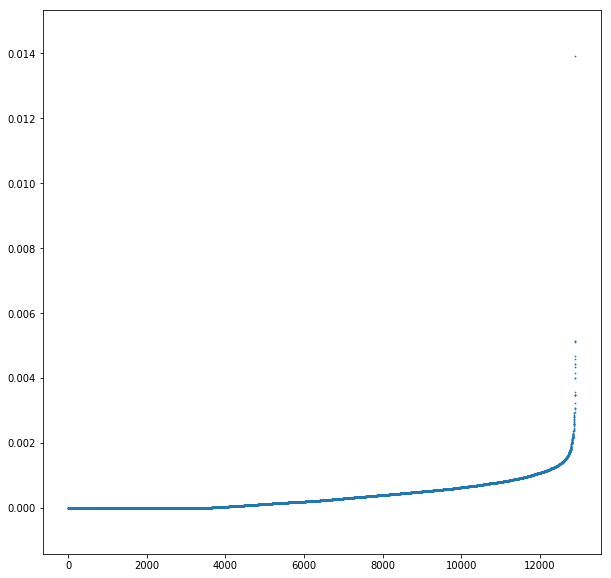

In [10]:
X = df[['Longitude', 'Latitude']].dropna()
X = X[start:end]

nbrs = NearestNeighbors(n_neighbors=5).fit(X)
distances, indices = nbrs.kneighbors(X)
y = np.sort(distances.mean(axis=1))
x = range(0, len(y))

plt.scatter(x,y, s=0.5)

/usr/local/lib/python3.5/site-packages/scipy/spatial/distance.py:364: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(um, vm) / (norm(um) * norm(vm))


1.11565561966


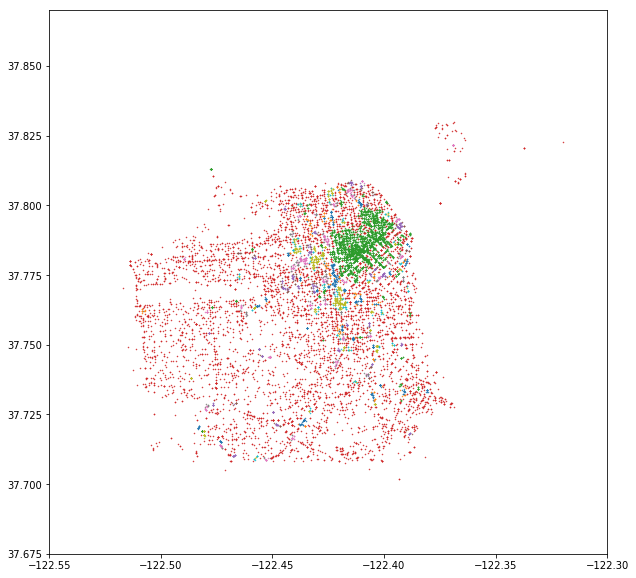

In [20]:
from scipy.stats import chi2_contingency

db = DBSCAN(eps=0.001, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
cluster = db.components_

ax = plt.subplot(111)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

correlations = np.array([])
fire_numbers = np.array([])
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    ax.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markersize=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    ax.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markersize=0.5)
    
    all_clust_members = X[class_member_mask]
    
    fire_numbers = np.append(fire_numbers, len(all_clust_members))
    
    cor = correlation(all_clust_members['Longitude'], all_clust_members['Latitude'])
    correlations = np.append(correlations, cor)
    
    #print(len(all_clust_members))
    #obs = np.array([all_clust_members['Longitude'], all_clust_members['Latitude']])
    #print(chi2_contingency(obs))

print("Mean Correlation between latitude and Longitude: {}".format(correlations[~np.isnan(correlations)].mean()))
clust_prob = fire_numbers/len(X)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()

In [ ]:
from scipy.spatial.distance import correlation

class_member_mask = (labels == 1)
x = X[class_member_mask]
print(len(x))
print(correlation(x['Longitude'], x['Latitude']))
ax.plot(x['Longitude'], x['Latitude'],'o', markersize=0.7)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()

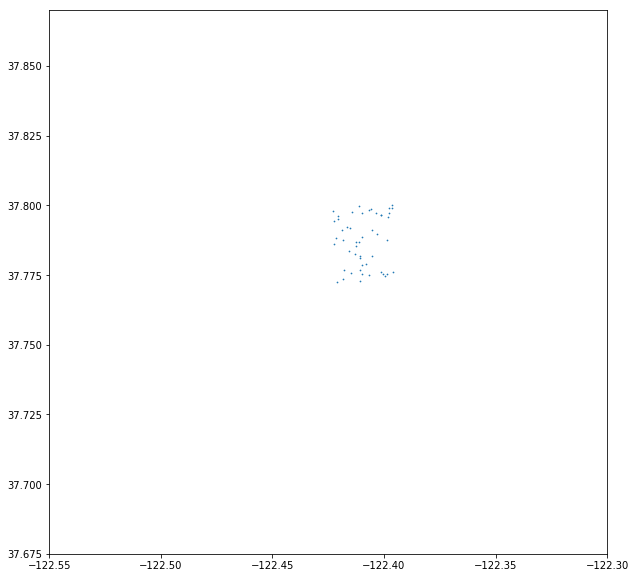

In [15]:
from scipy.spatial.distance import correlation

class_member_mask = (labels == 1)
points = X[class_member_mask]
x = np.random.uniform(min(points['Longitude']), max(points['Longitude']), 50)
y = np.random.uniform(min(points['Latitude']), max(points['Latitude']), 50)
ax = plt.subplot(111)
ax.plot(x, y,'o', markersize=0.7)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()

[[  37.77704785 -122.40476822]
 [  37.78574452 -122.41880649]
 [  37.72407817 -122.37748065]
 ..., 
 [  37.76031531 -122.44905063]
 [  37.797587   -122.43723862]
 [  37.73720713 -122.3204004 ]]
[ 37.77704785  37.78574452  37.72407817 ...,  37.76031531  37.797587
  37.73720713] [-122.40476822 -122.41880649 -122.37748065 ..., -122.44905063 -122.43723862
 -122.3204004 ]


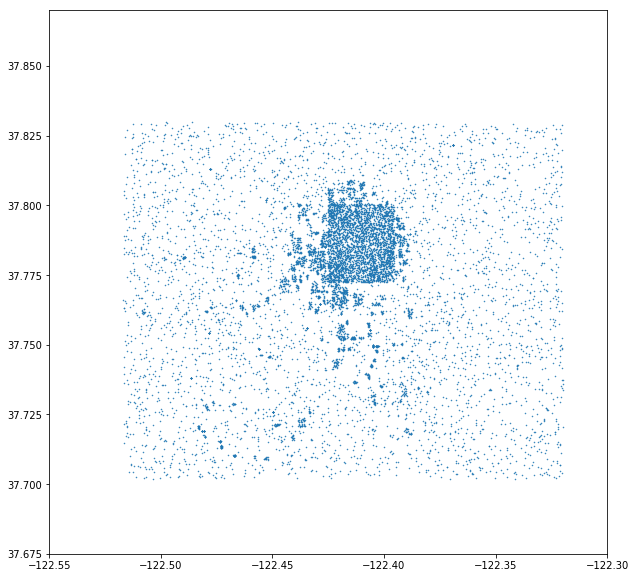

In [51]:
from simulation_package.GeoCoordSimulator import GeoCoordSimulator

gcs = GeoCoordSimulator(X)
gcs.calculate_clusters()
coord = gcs.get_random_coordinates(10000)
print(coord)
print(coord[:,0], coord[:, 1])
ax = plt.subplot(111)
ax.plot(coord[:,1], coord[:, 0],'o', markersize=0.5)
ax.set_xlim(-122.55, -122.3)
ax.set_ylim(37.675, 37.87)
plt.show()